# Claim Vector/Claim Map Visualization

To visualize the claim vectors/claim maps in instance_mode=="v5" we adapt the method from:

Panoptic DeepLab: https://arxiv.org/pdf/1911.10194.pdf

A Database and Evaluation Methodology for Optical Flow: https://www.microsoft.com/en-us/research/wp-content/uploads/2007/10/ofdatabase_iccv_07.pdf

The claim vectors are encoded in an HSV circle like manner, where color indicates direction and saturation indicates magnitude.

See the color sqaure below for a visualization

In [2]:
import flow_vis
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from skimage.io import imread

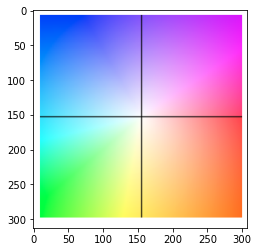

In [3]:
plt.imshow(imread("vector_coloring_data/Selection_022.png"))

In [4]:
flux = fits.getdata("vector_coloring_data/67-flux.fits")
background = fits.getdata("vector_coloring_data/67-background.fits")
center_of_mass = fits.getdata("vector_coloring_data/67-center_of_mass.fits")
claim_maps = fits.getdata("vector_coloring_data/67-claim_maps.fits")
claim_vectors = fits.getdata("vector_coloring_data/67-claim_vectors.fits")
claim_vectors.shape

(256, 256, 4, 5, 2)

In [5]:
# Scale function currently used on flux images in logging
def scale_image(data):

    ox = int(data.shape[0]/4)
    oy = int(data.shape[1]/4)
    nx = int(data.shape[0]/2)
    ny = int(data.shape[1]/2)

    s = np.std(data[ox:ox+nx,oy:oy+ny])
    m = np.mean(data[ox:ox+nx,oy:oy+ny])

    ret = (data-m)/s
    ret = np.log10((data-m)/s + 1.0e-6 - (data-m).min()/s)
    m = np.mean(ret)
    s = np.std(ret)

    ret[ret<m-0.5*s] = m-0.5*s
    ret[ret>m+2.0] = m+2.0
    ret = (ret - ret.min())/(ret.max()-ret.min())
    return ret

### Sample Enoding

Visualize flux, center of mass and background for validation of the vector outputs

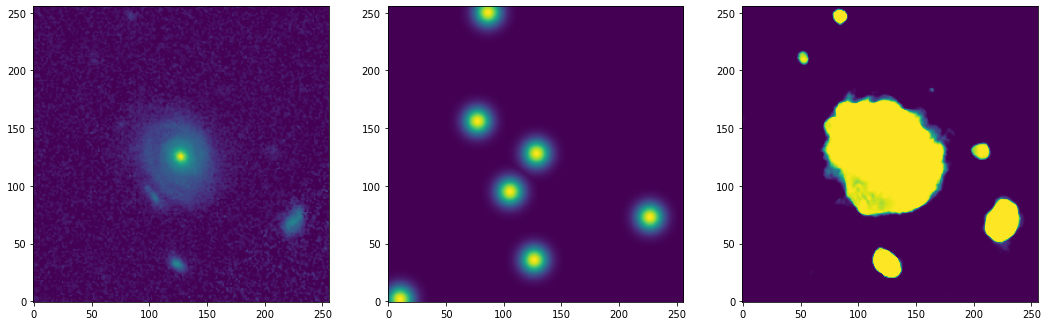

In [6]:
f, axes = plt.subplots(ncols=3, figsize=(18, 6))

arrs = [
    scale_image(flux[..., 0]), 
    center_of_mass[..., 0], 
    1 - background[..., 0]
]

for ax, arr in zip(axes.flat, arrs):
    ax.imshow(arr, origin="lower")

### Claim Vector visualization for the closest source contributing flux to a pixel as indicated by the source locations

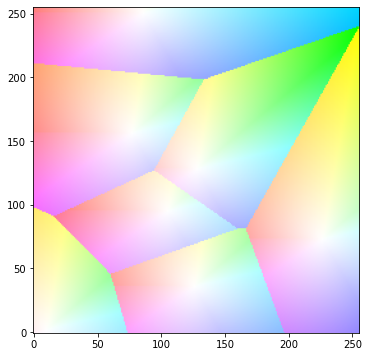

In [7]:
f, ax = plt.subplots(figsize=(6, 6))

# we have to do this flip because the claim vector 
# reference image uses origin!="lower"
single_cv = claim_vectors[:, :, 0, 0, :].copy()
single_cv[:, :, 0]  = single_cv[:, :, 0] * -1

ax.imshow(
    flow_vis.flow_to_color(
        single_cv[..., [1, 0]],
        convert_to_bgr=False
    ),
    origin="lower"
)

### Claim Vector Visualization with the center of mass image overlayed

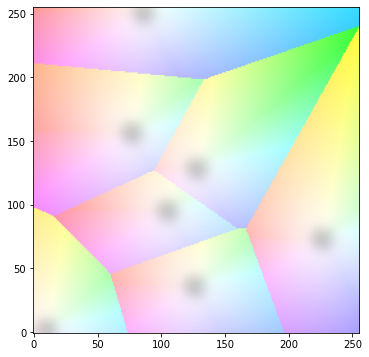

In [9]:
f, ax = plt.subplots(figsize=(6, 6))

# we have to do this flip because the claim vector 
# reference image uses origin!="lower"
single_cv = claim_vectors[:, :, 0, 0, :].copy()
single_cv[:, :, 0]  = single_cv[:, :, 0] * -1

ax.imshow(
    flow_vis.flow_to_color(
        single_cv[..., [1, 0]],
        convert_to_bgr=False
    ),
    origin="lower"
)
ax.imshow(
    center_of_mass[..., 0],
    cmap="Greys",
    origin="lower",
    alpha=0.2,
)

### Claim Vector visualization with background pixels filtered out

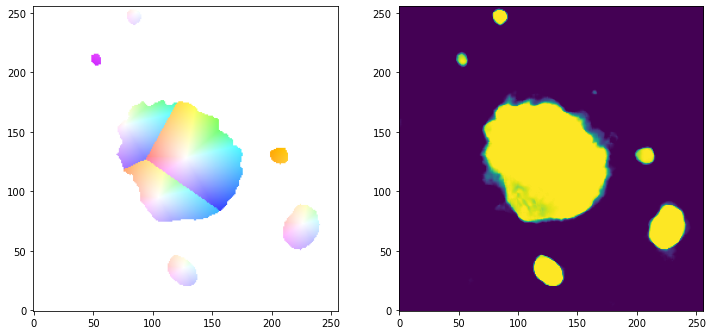

In [10]:
f, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

# we have to do this flip because the claim vector 
# reference image uses origin!="lower"
single_cv = claim_vectors[:, :, 0, 0, :].copy()
single_cv[:, :, 0]  = single_cv[:, :, 0] * -1

ax1.imshow(
    flow_vis.flow_to_color(
        single_cv[..., [1, 0]] * (background < 0.5) ,
        convert_to_bgr=False
    ),
    origin="lower"
)

ax2.imshow(1-background[..., 0], origin="lower")

### Claim Vector/Claim Map Visualization

The claim vectors are paired with their corresponding claim map on each row. Starting with the closest source and ending with furthest. The claim maps are set to have min/max cmap values of 0-1.

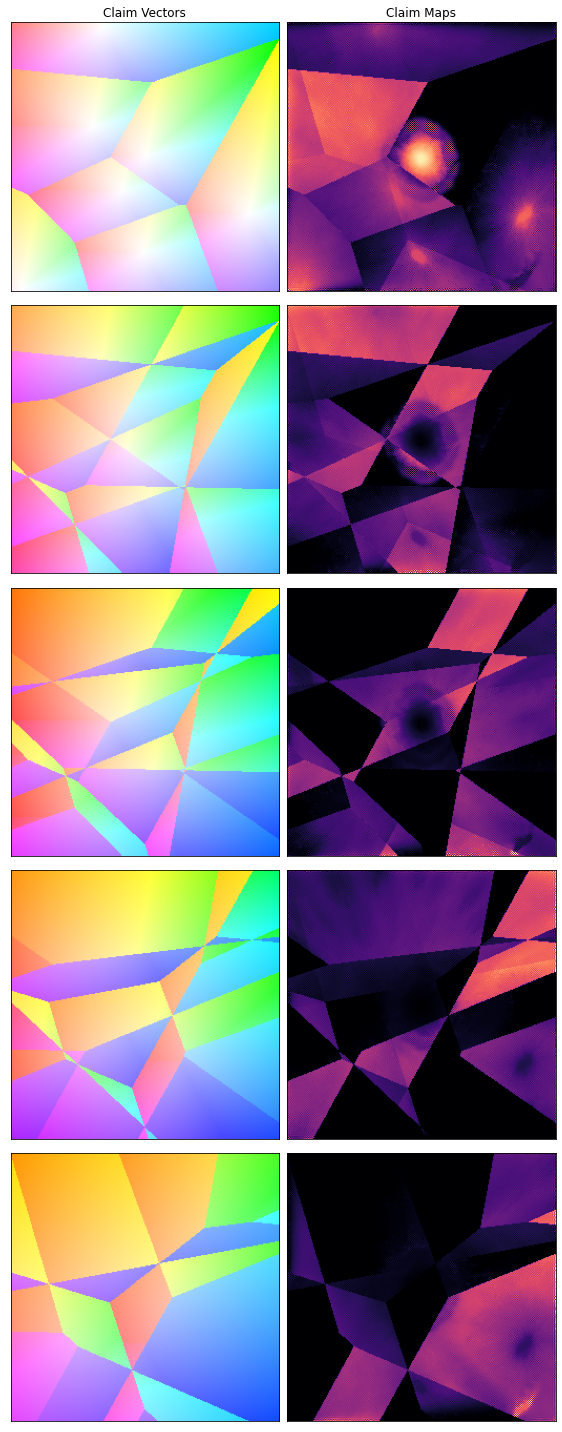

In [11]:
f, axes = plt.subplots(
    ncols=2, 
    nrows=5, 
    figsize=(8, 20),
)


for i, ax in enumerate(axes.flat):
    # we have to do this flip because the claim vector 
    # reference image uses origin!="lower"
    single_cv = claim_vectors[:, :, 0, i//2, :].copy()
    single_cv[:, :, 0]  = single_cv[:, :, 0] * -1
    
    # claim vector
    if i % 2 == 0:
        ax.imshow(
            flow_vis.flow_to_color(
                single_cv[..., [1, 0]],
                convert_to_bgr=False
            ),
            origin="lower"
        )
    # claim map
    else:
        ax.imshow(
            claim_maps[:, :, 0, i//2],
            vmin=0,
            vmax=1,
            cmap="magma",
            origin="lower",
        )
    ax.set_xticks([])
    ax.set_yticks([])

axes[0, 0].set_title("Claim Vectors")
axes[0, 1].set_title("Claim Maps")
plt.tight_layout()
plt.show()